In [104]:
import pandas as pd
import numpy as np
import re
from random import random
import emoji
from tqdm import notebook
def tqdm(x, **kargs):
    return notebook.tqdm(x, leave=False, **kargs)
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import torch
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [105]:
from simpletransformers.classification import MultiLabelClassificationModel, ClassificationModel
from sklearn.preprocessing import MultiLabelBinarizer

In [106]:
from simpletransformers.language_modeling import LanguageModelingModel

## Read input data

In [198]:
# df = pd.read_json('./source/train_gold.json', lines=True)
df = pd.read_json('./preprocessed/preprocess_train.json', lines=True)
df_new = df.copy()
df_new.head()

,idx,text,reply,categories
0,0,we can all agree that any song by Niall Horan .,oui oui,[yes]
1,1,Will you be install # ScottyFromMarketing ' ...,,[no]
2,2,Growing up my mum would call me a Nigga despit...,And he joins in ? ? ? Pour some hot grits o...,[smh]
3,3,Rest your head on my chest when the world feel...,😂😂😂😂😂,[wink]
4,4,Imagine Will Hernandez and Wills both doing a ...,,[yes]


In [199]:
categories_type = pd.read_json('./source/categories.json', lines=True)
categories_mapping = {v[0]: k for k, v in categories_type.to_dict('list').items()}

In [200]:
df_dev_ori = pd.read_json('./source/dev_unlabeled.json', lines=True)
df_dev = pd.read_json('./preprocessed/preprocess_dev.json', lines=True)
df_dev_result = df_dev.copy()[['text', 'reply']]
df_dev_result.head()

,text,reply
0,"Drop your cash app , use hashtag # BailoutHu...",$ tyratomaro # BailoutHumans
1,After interviewing with a few incredible peopl...,CONGRATS ! ! ! ! !
2,I know GTC festival not happening next month b...,
3,"Lordy , my daughter just said , "" I wonde...",
4,THE UNEMPLOYMENT CLAIM SYSTEM SUCKS SO MUCH DICK,Watching everyone else get their weekly unempl...


In [201]:
df_test_ori = pd.read_json('./source/test_unlabeled.json', lines=True)
df_test = pd.read_json('./source/test_unlabeled.json', lines=True)
df_test_result = df_test.copy()[['text', 'reply']]
df_test_result.head()

,text,reply
0,@Youngdeji_ I think if uzi and carti dropping ...,
1,For the third year in a row we’re discussing t...,
2,dababy album sounds like it was made for nigga...,That's why you bought it.
3,Majority of Indians don’t watch any sport othe...,@ZairaWasimmm got a great story because of the...
4,everybody is just now listening to @madisonbee...,


### Use multi-hot encoding and change column name

In [202]:
mlb = MultiLabelBinarizer()
multi_hot = mlb.fit_transform(df_new['categories'].values)
multi_hot_list = [list(_) for _ in multi_hot]

In [203]:
df_new['labels'] = multi_hot_list
df_new = df_new[['text', 'reply', 'labels']]
df_new.columns = ['text_a', 'text_b', 'labels']
df_dev_result.columns = ['text_a', 'text_b']
df_test_result.columns = ['text_a', 'text_b']

## Training language model first, can imporve accuracy!

In [88]:
# Output data to train_file for training LM
df_forLM = df_new.copy()
# df_forLM['text'] = ['<s> '] + df_new['text_a'] + [' </s></s> '] + df_new['text_b'] + [' <s>']
df_forLM['text'] = ['[CLS] '] + df_new['text_a'] + [' [SEP] '] + df_new['text_b'] + [' [SEP]']
# df_forLM_dev = df_dev_result.copy()
# df_forLM_dev['text'] = ['<s> '] + df_dev_result['text_a'] + [' </s></s> '] + df_dev_result['text_b'] + [' <s>']
# df_forLM_test = df_test_result.copy()
# df_forLM_test['text'] = ['<s> '] + df_test_result['text_a'] + [' [SEP] '] + df_test_result['text_b']
# pd.concat([df_forLM['text'], df_forLM_dev['text'], df_forLM_test['text']])[1]

In [89]:
df_forLM['text'].to_csv(r'LM/training.txt', header=None, index=None, sep=' ')
# pd.concat([df_forLM['text'], df_forLM_dev['text']]).to_csv(r'LM/training_dev.txt', header=None, index=None, sep=' ')
# pd.concat([df_forLM['text'], df_forLM_dev['text'], df_forLM_test['text']]).to_csv(r'LM/training_dev_test.txt', header=None, index=None, sep=' ')

In [97]:
train_lm_args = {
    "output_dir": "LM/formal_bert_cased_LM_training_preprocessed_5/",
    "cache_dir": "cache/",
    "best_model_dir": "LM/outputs/best_model/",

    "fp16": False,
    "fp16_opt_level": "O1",
    "max_seq_length": 113,
    "train_batch_size": 16,
    "eval_batch_size": 16,
    "gradient_accumulation_steps": 1,
    "num_train_epochs": 4,
    "weight_decay": 0,
    "learning_rate": 4e-5,
    "adam_epsilon": 1e-8,
    "warmup_ratio": 0.06,
    "warmup_steps": 0,
    "max_grad_norm": 1.0,
    "do_lower_case": False,
}
model = LanguageModelingModel("bert", "bert-base-cased", args=train_lm_args)

I0607 12:23:11.072587 139831797843776 tokenization_utils.py:1015] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt from cache at cache/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1
I0607 12:23:12.109906 139831797843776 configuration_utils.py:285] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at cache/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.9da767be51e1327499df13488672789394e2ca38b877837e52618a67d7002391
I0607 12:23:12.110625 139831797843776 configuration_utils.py:321] Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 5

In [98]:
model.train_model('LM/training.txt')

I0607 12:23:14.607279 139831797843776 language_modeling_utils.py:181]  Creating features from dataset file at cache/


I0607 12:23:17.405872 139831797843776 language_modeling_utils.py:229]  Saving features into cached file cache/bert_cached_lm_111_training.txt
I0607 12:23:17.435646 139831797843776 language_modeling_model.py:473]  Training started


Running loss: 2.933553

I0607 12:25:43.664306 139831797843776 configuration_utils.py:144] Configuration saved in LM/formal_bert_cased_LM_training_preprocessed_5/checkpoint-727-epoch-1/config.json


I0607 12:25:43.886026 139831797843776 modeling_utils.py:483] Model weights saved in LM/formal_bert_cased_LM_training_preprocessed_5/checkpoint-727-epoch-1/pytorch_model.bin


Running loss: 2.517798

I0607 12:28:10.789751 139831797843776 configuration_utils.py:144] Configuration saved in LM/formal_bert_cased_LM_training_preprocessed_5/checkpoint-1454-epoch-2/config.json


I0607 12:28:10.995953 139831797843776 modeling_utils.py:483] Model weights saved in LM/formal_bert_cased_LM_training_preprocessed_5/checkpoint-1454-epoch-2/pytorch_model.bin


Running loss: 2.503130

I0607 12:30:01.781956 139831797843776 configuration_utils.py:144] Configuration saved in LM/formal_bert_cased_LM_training_preprocessed_5/checkpoint-2000/config.json


Running loss: 2.148162

I0607 12:30:01.995476 139831797843776 modeling_utils.py:483] Model weights saved in LM/formal_bert_cased_LM_training_preprocessed_5/checkpoint-2000/pytorch_model.bin


Running loss: 2.354822

I0607 12:30:38.957110 139831797843776 configuration_utils.py:144] Configuration saved in LM/formal_bert_cased_LM_training_preprocessed_5/checkpoint-2181-epoch-3/config.json


I0607 12:30:39.165402 139831797843776 modeling_utils.py:483] Model weights saved in LM/formal_bert_cased_LM_training_preprocessed_5/checkpoint-2181-epoch-3/pytorch_model.bin


Running loss: 2.152264

I0607 12:33:06.605767 139831797843776 configuration_utils.py:144] Configuration saved in LM/formal_bert_cased_LM_training_preprocessed_5/checkpoint-2908-epoch-4/config.json


I0607 12:33:06.813516 139831797843776 modeling_utils.py:483] Model weights saved in LM/formal_bert_cased_LM_training_preprocessed_5/checkpoint-2908-epoch-4/pytorch_model.bin
I0607 12:33:07.245698 139831797843776 configuration_utils.py:144] Configuration saved in LM/formal_bert_cased_LM_training_preprocessed_5/config.json


I0607 12:33:07.453769 139831797843776 modeling_utils.py:483] Model weights saved in LM/formal_bert_cased_LM_training_preprocessed_5/pytorch_model.bin
I0607 12:33:07.467456 139831797843776 language_modeling_model.py:402]  Training of bert model complete. Saved to LM/formal_bert_cased_LM_training_preprocessed_5/.


## Training model

In [99]:
train_args = {
    "output_dir": "model_results_gpu/formal_bert_cased_LM_training_preprocessed_5/",
    "cache_dir": "cache/",
    "best_model_dir": "model_results_gpu/outputs/best_model/",

    "fp16": False,
    "fp16_opt_level": "O1",
    "max_seq_length": 113,
    "train_batch_size": 16,
    "eval_batch_size": 16,
    "gradient_accumulation_steps": 1,
    "num_train_epochs": 4,
    "weight_decay": 0,
    "learning_rate": 4e-5,
    "adam_epsilon": 1e-8,
    "warmup_ratio": 0.06,
    "warmup_steps": 0,
    "max_grad_norm": 1.0,
    "do_lower_case": False,

    "logging_steps": 50,
    "evaluate_during_training": False,
    "evaluate_during_training_steps": 2000,
    "evaluate_during_training_verbose": False,
    "use_cached_eval_features": False,
    "save_eval_checkpoints": False,
    "save_steps": 2000,
    "no_cache": True,
    "save_model_every_epoch": True,
    "tensorboard_dir": None,

    "overwrite_output_dir": False,
    "reprocess_input_data": True,

    "n_gpu": 1,
    "silent": False,
    "use_multiprocessing": False,

    "wandb_project": None,
    "wandb_kwargs": {},

    "use_early_stopping": True,
    "early_stopping_patience": 3,
    "early_stopping_delta": 0,
    "early_stopping_metric": "eval_loss",
    "early_stopping_metric_minimize": True,

    "manual_seed": None,
    "encoding": None,
    "config": {}
}
model = MultiLabelClassificationModel('bert', 'LM/formal_bert_cased_LM_training_preprocessed_5', num_labels=43, args=train_args)

I0607 12:35:43.616866 139831797843776 configuration_utils.py:283] loading configuration file LM/formal_bert_cased_LM_training_preprocessed_5/config.json
I0607 12:35:43.617649 139831797843776 configuration_utils.py:321] Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "LABEL_26",
  

In [100]:
# pos_weight = [1 for _ in range(43)]
# most = ['applause', 'hug', 'agree']
# for each_most in most:
#     pos_weight[categories_mapping[each_most]] = 1.5

In [101]:
model.train_model(df_new)

I0607 12:35:48.258174 139831797843776 classification_model.py:801]  Converting to features started. Cache is not used.


I0607 12:35:58.017035 139831797843776 classification_model.py:367]    Starting fine-tuning.


Running loss: 0.133169

I0607 12:41:21.173754 139831797843776 configuration_utils.py:144] Configuration saved in model_results_gpu/formal_bert_cased_LM_training_preprocessed_5/checkpoint-2000/config.json
I0607 12:41:21.384770 139831797843776 modeling_utils.py:483] Model weights saved in model_results_gpu/formal_bert_cased_LM_training_preprocessed_5/checkpoint-2000/pytorch_model.bin
I0607 12:41:21.828613 139831797843776 configuration_utils.py:144] Configuration saved in model_results_gpu/formal_bert_cased_LM_training_preprocessed_5/checkpoint-2000-epoch-1/config.json


I0607 12:41:22.036527 139831797843776 modeling_utils.py:483] Model weights saved in model_results_gpu/formal_bert_cased_LM_training_preprocessed_5/checkpoint-2000-epoch-1/pytorch_model.bin


Running loss: 0.113680

I0607 12:46:46.606186 139831797843776 configuration_utils.py:144] Configuration saved in model_results_gpu/formal_bert_cased_LM_training_preprocessed_5/checkpoint-4000/config.json
I0607 12:46:46.812139 139831797843776 modeling_utils.py:483] Model weights saved in model_results_gpu/formal_bert_cased_LM_training_preprocessed_5/checkpoint-4000/pytorch_model.bin
I0607 12:46:47.244852 139831797843776 configuration_utils.py:144] Configuration saved in model_results_gpu/formal_bert_cased_LM_training_preprocessed_5/checkpoint-4000-epoch-2/config.json


I0607 12:46:47.454509 139831797843776 modeling_utils.py:483] Model weights saved in model_results_gpu/formal_bert_cased_LM_training_preprocessed_5/checkpoint-4000-epoch-2/pytorch_model.bin


Running loss: 0.080718

I0607 12:52:12.142231 139831797843776 configuration_utils.py:144] Configuration saved in model_results_gpu/formal_bert_cased_LM_training_preprocessed_5/checkpoint-6000/config.json
I0607 12:52:12.347472 139831797843776 modeling_utils.py:483] Model weights saved in model_results_gpu/formal_bert_cased_LM_training_preprocessed_5/checkpoint-6000/pytorch_model.bin
I0607 12:52:12.775434 139831797843776 configuration_utils.py:144] Configuration saved in model_results_gpu/formal_bert_cased_LM_training_preprocessed_5/checkpoint-6000-epoch-3/config.json


I0607 12:52:12.980890 139831797843776 modeling_utils.py:483] Model weights saved in model_results_gpu/formal_bert_cased_LM_training_preprocessed_5/checkpoint-6000-epoch-3/pytorch_model.bin


Running loss: 0.101711

I0607 12:57:37.641493 139831797843776 configuration_utils.py:144] Configuration saved in model_results_gpu/formal_bert_cased_LM_training_preprocessed_5/checkpoint-8000/config.json
I0607 12:57:37.846687 139831797843776 modeling_utils.py:483] Model weights saved in model_results_gpu/formal_bert_cased_LM_training_preprocessed_5/checkpoint-8000/pytorch_model.bin
I0607 12:57:38.274803 139831797843776 configuration_utils.py:144] Configuration saved in model_results_gpu/formal_bert_cased_LM_training_preprocessed_5/checkpoint-8000-epoch-4/config.json


I0607 12:57:38.478326 139831797843776 modeling_utils.py:483] Model weights saved in model_results_gpu/formal_bert_cased_LM_training_preprocessed_5/checkpoint-8000-epoch-4/pytorch_model.bin
I0607 12:57:38.924200 139831797843776 configuration_utils.py:144] Configuration saved in model_results_gpu/formal_bert_cased_LM_training_preprocessed_5/config.json


I0607 12:57:39.132042 139831797843776 modeling_utils.py:483] Model weights saved in model_results_gpu/formal_bert_cased_LM_training_preprocessed_5/pytorch_model.bin
I0607 12:57:39.147009 139831797843776 classification_model.py:279]  Training of bert model complete. Saved to model_results_gpu/formal_bert_cased_LM_training_preprocessed_5/.


### Load model (unused can comment)

In [97]:
# model = MultiLabelClassificationModel('roberta', 'model_results_gpu/formal_roberta_training_preprocessed_#112')

### Evaluating model for LRAP and mAP

In [102]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(df_new)
print(result)


{'LRAP': 0.6068392281713387, 'eval_loss': 0.08760639537125826}


In [103]:
avg_map = 0
total_predict = []

unpredict_class = defaultdict(lambda: 0)
record_unpredict_class = defaultdict(lambda: defaultdict(lambda: 0))

for eid, each_outputs in enumerate(model_outputs):
    predict_class = []
    correct = 0
    sort_index = sorted(range(len(model_outputs[eid])), key=lambda k: model_outputs[eid][k], reverse=True)
    for key, value in categories_mapping.items():
        if value in sort_index[0:6]:
            predict_class.append(key)
            
    # Check correctness
    for correct_class in df['categories'][eid]:
        if correct_class in predict_class:
            correct += 1
    
    # Check what not predicted correct
    check = predict_class.copy()
    unmatch = df['categories'][eid].copy()
    for each_class in df['categories'][eid]:
        if each_class not in predict_class:
            unpredict_class[each_class] += 1
        else:
            unmatch.remove(each_class)
            check.remove(each_class)
    for each_class in unmatch:
        for each_check in check:
            record_unpredict_class[each_class][each_check] += 1
    
    avg_map += (correct / len(df['categories'][eid]))
    total_predict.append(predict_class)

avg_map /= len(df['categories'])
print("avg map = {}".format(avg_map))

avg map = 0.7497932291666636


### Analyze why predict wrong

In [17]:
def softmax(scores):
    exp = np.exp(scores)
    scores = exp / np.sum(exp)
    return scores

In [21]:
avg_map = 0
total_predict = []

predict_ok_agree = 0
index_correct = np.zeros(6)
unpredict_class = defaultdict(lambda: 0)
record_unpredict_class = defaultdict(lambda: defaultdict(lambda: 0))

for eid, each_outputs in enumerate(model_outputs):
    weighted_outputs = softmax(model_outputs[eid])
    predict_class = []
    correct = 0
    sort_index = sorted(range(len(model_outputs[eid])), key=lambda k: weighted_outputs[k], reverse=True)
    for key, value in categories_mapping.items():
        if value in sort_index[0:6]:
            predict_class.append(key)

    # Check correctness
    for correct_class in df['categories'][eid]:
        if correct_class in predict_class:
            correct += 1
            index_correct[predict_class.index(correct_class)] += 1
            
    # Check what not predicted correct
    check = predict_class.copy()
    unmatch = df['categories'][eid].copy()
    for each_class in df['categories'][eid]:
        if each_class not in predict_class:
            unpredict_class[each_class] += 1
        else:
            unmatch.remove(each_class)
            check.remove(each_class)
    for each_class in unmatch:
        for each_check in check:
            record_unpredict_class[each_class][each_check] += 1
    
    avg_map += (correct / len(df['categories'][eid]))
    total_predict.append(predict_class)

# avg_map /= len(df['categories'])
print("avg map = {} ({} / {})".format(avg_map / len(df['categories']), avg_map, len(df['categories'])))

avg map = 0.690888020833331 (22108.41666666659 / 32000)


In [26]:
index_correct

array([5625., 5501., 3829., 5961., 5961., 5344.])

In [100]:
both_yes_no = 0
only_yes = 0
only_no = 0
for i in range(len(df)):
    if 'yes' in df['categories'][i] and 'no' in df['categories'][i]:
        both_yes_no += 1
    elif 'yes' in df['categories'][i] and 'no' not in df['categories'][i]:
        only_yes += 1
    elif 'yes' not in df['categories'][i] and 'no' in df['categories'][i]:
        only_no += 1
print(both_yes_no)
print(only_yes)
print(only_no)

0
2719
2185


In [106]:
# sorted(categories_dict.items(), key=lambda d: d[1], reverse=True)
record_unpredict_class['ok']

defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
            {'eww': 66,
             'idk': 96,
             'oh_snap': 90,
             'omg': 203,
             'scared': 85,
             'shocked': 264,
             'agree': 370,
             'applause': 388,
             'no': 177,
             'seriously': 276,
             'slow_clap': 185,
             'yes': 357,
             'awww': 141,
             'dance': 159,
             'happy_dance': 135,
             'please': 65,
             'wink': 40,
             'facepalm': 197,
             'sigh': 176,
             'smh': 200,
             'popcorn': 55,
             'thank_you': 86,
             'hearts': 48,
             'hug': 82,
             'you_got_this': 59,
             'oops': 62,
             'high_five': 21,
             'good_luck': 73,
             'win': 16,
             'shrug': 34,
             'thumbs_up': 28,
             'eye_roll': 63,
             'do_not_want': 8,
             'want': 6,
   

In [102]:
sorted(unpredict_class.items(), key=lambda d: d[1], reverse=True) 

[('ok', 762),
 ('shrug', 634),
 ('eww', 610),
 ('oops', 579),
 ('omg', 561),
 ('scared', 545),
 ('eye_roll', 542),
 ('oh_snap', 493),
 ('no', 490),
 ('idk', 479),
 ('wink', 466),
 ('high_five', 460),
 ('shocked', 441),
 ('deal_with_it', 429),
 ('yawn', 426),
 ('sigh', 411),
 ('thumbs_up', 390),
 ('awww', 367),
 ('win', 356),
 ('agree', 348),
 ('popcorn', 340),
 ('yes', 304),
 ('smh', 302),
 ('thank_you', 300),
 ('fist_bump', 292),
 ('sorry', 287),
 ('applause', 282),
 ('seriously', 265),
 ('facepalm', 264),
 ('do_not_want', 241),
 ('want', 231),
 ('please', 225),
 ('thumbs_down', 220),
 ('dance', 217),
 ('slow_clap', 214),
 ('happy_dance', 208),
 ('yolo', 197),
 ('good_luck', 179),
 ('mic_drop', 170),
 ('kiss', 166),
 ('you_got_this', 151),
 ('hearts', 124),
 ('hug', 100)]

## Predict results [pair sentance](https://simpletransformers.ai/docs/classification-data-formats/)

In [15]:
# text + [SEP] + reply
to_predict = []
for i in range(len(df_dev_result)):
    # for roberta format
    text_reply = '<s> ' + df_dev_result['text_a'][i] + ' </s></s> ' + df_dev_result['text_b'][i] + ' <s>'
#     for bert format
#     text_reply = '[CLS] ' + df_dev_result['text_a'][i] + ' [SEP] ' + df_dev_result['text_b'][i] + ' [SEP]'
    to_predict.append(text_reply)

In [16]:
predictions, raw_outputs = model.predict(to_predict)

I0606 07:59:05.914636 140151191160640 classification_model.py:801]  Converting to features started. Cache is not used.


In [17]:
total_predict = []
for eid, row in enumerate(raw_outputs):
    predict_class = []
    correct = 0
    sort_index = sorted(range(len(row)), key=lambda k: row[k], reverse=True)
    for key, value in categories_mapping.items():
        if value in sort_index[0:6]:
            predict_class.append(key)
    total_predict.append(predict_class)

In [18]:
df_dev_ori['categories'] = total_predict

In [19]:
df_dev_ori.head()

,idx,text,reply,categories
0,32000,"Drop your cash app, use hashtag #BailoutHumansNow",$tyratomaro #BailoutHumans,"[applause, dance, good_luck, happy_dance, plea..."
1,32001,After interviewing with a few incredible peopl...,CONGRATS!!!!!,"[applause, high_five, slow_clap, thumbs_up, wi..."
2,32002,I know GTC festival not happening next month b...,,"[idk, no, oops, scared, shrug, sigh]"
3,32003,"Lordy, my daughter just said, “I wonder how th...",,"[facepalm, oh_snap, omg, scared, shocked, smh]"
4,32004,THE UNEMPLOYMENT CLAIM SYSTEM SUCKS SO MUCH DICK,Watching everyone else get their weekly unempl...,"[eye_roll, facepalm, seriously, shrug, sigh, smh]"


In [20]:
df_dev_ori.to_json('./results/dev.json', orient='records', lines=True)

## Power n weighted sum to blend models, average same model type first

In [165]:
import csv
from os import listdir
from os.path import isfile
from operator import add 

### Evaluate training data

In [131]:
to_predict = []
for i in range(len(df_new)):
    # for roberta format
    text_reply = '<s> ' + df_new['text_a'][i] + ' </s></s> ' + df_new['text_b'][i] + ' <s>'
#     for bert format
#     text_reply = '[CLS] ' + df_dev_result['text_a'][i] + ' [SEP] ' + df_dev_result['text_b'][i] + ' [SEP]'
    to_predict.append(text_reply)

#### Predict all roberta models (need to change path)

In [130]:
model_roberta_base = MultiLabelClassificationModel('roberta', 'model_results_gpu/formal_roberta_training_preprocessed_#112/')
predictions_roberta_base, raw_outputs_roberta_base = model_roberta_base.predict(to_predict)

I0607 14:08:24.240644 139831797843776 configuration_utils.py:283] loading configuration file model_results_gpu/formal_roberta_training_preprocessed_#112/config.json
I0607 14:08:24.241528 139831797843776 configuration_utils.py:321] Model config RobertaConfig {
  "architectures": [
    "RobertaForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "2

In [133]:
with open("./final_results/roberta_10.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(raw_outputs_roberta_base)

#### Predict all cased and uncased bert models (need to change path)

In [135]:
for model_idx in range(1, 6):
    model_bert_base = MultiLabelClassificationModel('bert', 'model_results_gpu/formal_bert_uncased_LM_training_preprocessed_' + str(model_idx) + '/')
    to_predict = []
    for i in range(len(df_new)):
        # for roberta format
#         text_reply = '<s> ' + df_new['text_a'][i] + ' </s></s> ' + df_new['text_b'][i] + ' <s>'
    #     for bert format
        text_reply = '[CLS] ' + df_new['text_a'][i] + ' [SEP] ' + df_new['text_b'][i] + ' [SEP]'
        to_predict.append(text_reply)
    predictions_bert_base, raw_outputs_bert_base = model_bert_base.predict(to_predict)
    with open("./final_results/bert_uncase_" + str(model_idx) + ".csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(raw_outputs_bert_base)

I0607 14:23:49.151986 139831797843776 configuration_utils.py:283] loading configuration file model_results_gpu/formal_bert_uncased_LM_training_preprocessed_1/config.json
I0607 14:23:49.153757 139831797843776 configuration_utils.py:321] Model config BertConfig {
  "architectures": [
    "BertForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "

I0607 14:25:48.131691 139831797843776 configuration_utils.py:283] loading configuration file model_results_gpu/formal_bert_uncased_LM_training_preprocessed_2/config.json
I0607 14:25:48.132866 139831797843776 configuration_utils.py:321] Model config BertConfig {
  "architectures": [
    "BertForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "

I0607 14:27:47.512206 139831797843776 configuration_utils.py:283] loading configuration file model_results_gpu/formal_bert_uncased_LM_training_preprocessed_3/config.json
I0607 14:27:47.513008 139831797843776 configuration_utils.py:321] Model config BertConfig {
  "architectures": [
    "BertForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "

I0607 14:29:46.789490 139831797843776 configuration_utils.py:283] loading configuration file model_results_gpu/formal_bert_uncased_LM_training_preprocessed_4/config.json
I0607 14:29:46.790417 139831797843776 configuration_utils.py:321] Model config BertConfig {
  "architectures": [
    "BertForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "

I0607 14:31:46.289960 139831797843776 configuration_utils.py:283] loading configuration file model_results_gpu/formal_bert_uncased_LM_training_preprocessed_5/config.json
I0607 14:31:46.291116 139831797843776 configuration_utils.py:321] Model config BertConfig {
  "architectures": [
    "BertForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "

In [204]:
files = listdir('./final_results/')
roberta_prob = np.zeros([len(df_new), len(categories_mapping)])
bert_uncase_prob = np.zeros([len(df_new), len(categories_mapping)])
bert_case_prob = np.zeros([len(df_new), len(categories_mapping)])
for f in files:
    if f.find('.') != 0:
        model_prob = pd.read_csv('./final_results/' + f, header=None)
        probability_list = model_prob.values.tolist()
        if f.find('roberta') >= 0:
            roberta_prob = np.add(roberta_prob, probability_list)
        if f.find('_case_') >= 0:
            bert_case_prob = np.add(bert_case_prob, probability_list)
        if f.find('uncase') >= 0:
            bert_uncase_prob = np.add(bert_uncase_prob, probability_list)

### Sum up all probabilities and average

In [205]:
roberta_count = 10
bert_count = 5
roberta_prob /= roberta_count
bert_case_prob /= bert_count
bert_uncase_prob /= bert_count

### Power 3.5 of weighted sum

In [206]:
P = 3.5
total_predict = []
for eid, row_roberta_base in enumerate(roberta_prob):
    row = (row_roberta_base ** P) * 3.0 + \
            (bert_case_prob[eid] ** P) * 0.8 + (bert_uncase_prob[eid] ** P) * 0.8 
    predict_class = []
    correct = 0
    sort_index = sorted(range(len(row)), key=lambda k: row[k], reverse=True)
    for key, value in categories_mapping.items():
        if value in sort_index[0:6]:
            predict_class.append(key)
            
    # Check correctness
    correct = 0
    for correct_class in df['categories'][eid]:
        if correct_class in predict_class:
            correct += 1
    total_predict.append(predict_class)
    avg_map += (correct / len(df['categories'][eid]))
print("avg map = {} ({} / {})".format(avg_map / len(df['categories']), avg_map, len(df['categories'])))

avg map = 0.715995306038411 (22911.84979322915 / 32000)


### Predicting test data

In [216]:
to_predict = []
for i in range(len(df_test_result)):
    # for roberta format
    text_reply = '<s> ' + df_test_result['text_a'][i] + ' </s></s> ' + df_test_result['text_b'][i] + ' <s>'
#     for bert format
#     text_reply = '[CLS] ' + df_test_result['text_a'][i] + ' [SEP] ' + df_test_result['text_b'][i] + ' [SEP]'
    to_predict.append(text_reply)

In [212]:
for model_idx in range(2, 10):
    model_roberta_base = MultiLabelClassificationModel('roberta', 'model_results_gpu/formal_roberta_LM_training_preprocessed_' + str(model_idx) + '/')
    predictions_roberta_base, raw_outputs_roberta_base = model_roberta_base.predict(to_predict)
    with open("./final_results/test/roberta_" + str(model_idx) + ".csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(raw_outputs_roberta_base)

I0607 15:43:26.503050 139831797843776 configuration_utils.py:283] loading configuration file model_results_gpu/formal_roberta_LM_training_preprocessed_2/config.json
I0607 15:43:26.503748 139831797843776 configuration_utils.py:321] Model config RobertaConfig {
  "architectures": [
    "RobertaForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "2

I0607 15:43:43.303965 139831797843776 configuration_utils.py:283] loading configuration file model_results_gpu/formal_roberta_LM_training_preprocessed_3/config.json
I0607 15:43:43.304652 139831797843776 configuration_utils.py:321] Model config RobertaConfig {
  "architectures": [
    "RobertaForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "2

I0607 15:43:59.558231 139831797843776 configuration_utils.py:283] loading configuration file model_results_gpu/formal_roberta_LM_training_preprocessed_4/config.json
I0607 15:43:59.558848 139831797843776 configuration_utils.py:321] Model config RobertaConfig {
  "architectures": [
    "RobertaForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "2

I0607 15:44:15.920140 139831797843776 configuration_utils.py:283] loading configuration file model_results_gpu/formal_roberta_LM_training_preprocessed_5/config.json
I0607 15:44:15.920892 139831797843776 configuration_utils.py:321] Model config RobertaConfig {
  "architectures": [
    "RobertaForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "2

I0607 15:44:32.269422 139831797843776 configuration_utils.py:283] loading configuration file model_results_gpu/formal_roberta_LM_training_preprocessed_6/config.json
I0607 15:44:32.270106 139831797843776 configuration_utils.py:321] Model config RobertaConfig {
  "architectures": [
    "RobertaForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "2

I0607 15:44:48.723681 139831797843776 configuration_utils.py:283] loading configuration file model_results_gpu/formal_roberta_LM_training_preprocessed_7/config.json


I0607 15:44:48.724304 139831797843776 configuration_utils.py:321] Model config RobertaConfig {
  "architectures": [
    "RobertaForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "LABEL_26",
    "27": "LABEL_27",
    "28": "LABEL_28",
    "29": "LABEL_29",
    "30": "LABEL_

I0607 15:45:05.475127 139831797843776 configuration_utils.py:283] loading configuration file model_results_gpu/formal_roberta_LM_training_preprocessed_8/config.json
I0607 15:45:05.475844 139831797843776 configuration_utils.py:321] Model config RobertaConfig {
  "architectures": [
    "RobertaForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "2

I0607 15:45:21.836648 139831797843776 configuration_utils.py:283] loading configuration file model_results_gpu/formal_roberta_LM_training_preprocessed_9/config.json
I0607 15:45:21.837343 139831797843776 configuration_utils.py:321] Model config RobertaConfig {
  "architectures": [
    "RobertaForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "2

I0607 15:45:21.837731 139831797843776 modeling_utils.py:648] loading weights file model_results_gpu/formal_roberta_LM_training_preprocessed_9/pytorch_model.bin
I0607 15:45:24.301992 139831797843776 tokenization_utils.py:929] Model name 'model_results_gpu/formal_roberta_LM_training_preprocessed_9/' not found in model shortcut name list (roberta-base, roberta-large, roberta-large-mnli, distilroberta-base, roberta-base-openai-detector, roberta-large-openai-detector). Assuming 'model_results_gpu/formal_roberta_LM_training_preprocessed_9/' is a path, a model identifier, or url to a directory containing tokenizer files.
I0607 15:45:24.302589 139831797843776 tokenization_utils.py:958] Didn't find file model_results_gpu/formal_roberta_LM_training_preprocessed_9/added_tokens.json. We won't load it.
I0607 15:45:24.302959 139831797843776 tokenization_utils.py:1013] loading file model_results_gpu/formal_roberta_LM_training_preprocessed_9/vocab.json
I0607 15:45:24.303284 139831797843776 tokenizatio

In [217]:
for bert_type in ['uncased', 'cased']:
    for model_idx in range(1, 6):
        model_bert_base = MultiLabelClassificationModel('bert', 'model_results_gpu/formal_bert_' + bert_type + '_LM_training_preprocessed_' + str(model_idx) + '/')
        predictions_bert_base, raw_outputs_bert_base = model_bert_base.predict(to_predict)
        with open("./final_results/test/bert_" + bert_type + "_" + str(model_idx) + ".csv", "w") as f:
            writer = csv.writer(f)
            writer.writerows(raw_outputs_bert_base)

I0607 16:23:41.772013 139831797843776 configuration_utils.py:283] loading configuration file model_results_gpu/formal_bert_uncased_LM_training_preprocessed_1/config.json
I0607 16:23:41.772970 139831797843776 configuration_utils.py:321] Model config BertConfig {
  "architectures": [
    "BertForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "

I0607 16:23:57.717469 139831797843776 configuration_utils.py:283] loading configuration file model_results_gpu/formal_bert_uncased_LM_training_preprocessed_2/config.json
I0607 16:23:57.718147 139831797843776 configuration_utils.py:321] Model config BertConfig {
  "architectures": [
    "BertForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "

I0607 16:24:13.679250 139831797843776 configuration_utils.py:283] loading configuration file model_results_gpu/formal_bert_uncased_LM_training_preprocessed_3/config.json
I0607 16:24:13.679941 139831797843776 configuration_utils.py:321] Model config BertConfig {
  "architectures": [
    "BertForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "

I0607 16:24:29.698691 139831797843776 configuration_utils.py:283] loading configuration file model_results_gpu/formal_bert_uncased_LM_training_preprocessed_4/config.json
I0607 16:24:29.699383 139831797843776 configuration_utils.py:321] Model config BertConfig {
  "architectures": [
    "BertForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "

I0607 16:24:46.108386 139831797843776 configuration_utils.py:283] loading configuration file model_results_gpu/formal_bert_uncased_LM_training_preprocessed_5/config.json
I0607 16:24:46.109060 139831797843776 configuration_utils.py:321] Model config BertConfig {
  "architectures": [
    "BertForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "

I0607 16:25:02.113587 139831797843776 configuration_utils.py:283] loading configuration file model_results_gpu/formal_bert_cased_LM_training_preprocessed_1/config.json
I0607 16:25:02.114185 139831797843776 configuration_utils.py:321] Model config BertConfig {
  "architectures": [
    "BertForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25

I0607 16:25:18.113335 139831797843776 configuration_utils.py:283] loading configuration file model_results_gpu/formal_bert_cased_LM_training_preprocessed_2/config.json
I0607 16:25:18.113996 139831797843776 configuration_utils.py:321] Model config BertConfig {
  "architectures": [
    "BertForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25

I0607 16:25:34.080593 139831797843776 configuration_utils.py:283] loading configuration file model_results_gpu/formal_bert_cased_LM_training_preprocessed_3/config.json
I0607 16:25:34.081313 139831797843776 configuration_utils.py:321] Model config BertConfig {
  "architectures": [
    "BertForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25

I0607 16:25:50.175452 139831797843776 configuration_utils.py:283] loading configuration file model_results_gpu/formal_bert_cased_LM_training_preprocessed_4/config.json
I0607 16:25:50.176114 139831797843776 configuration_utils.py:321] Model config BertConfig {
  "architectures": [
    "BertForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25

I0607 16:26:06.585084 139831797843776 configuration_utils.py:283] loading configuration file model_results_gpu/formal_bert_cased_LM_training_preprocessed_5/config.json
I0607 16:26:06.585695 139831797843776 configuration_utils.py:321] Model config BertConfig {
  "architectures": [
    "BertForMultiLabelSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25

In [218]:
files = listdir('./final_results/test/')
roberta_prob = np.zeros([len(df_test_result), len(categories_mapping)])
bert_uncase_prob = np.zeros([len(df_test_result), len(categories_mapping)])
bert_case_prob = np.zeros([len(df_test_result), len(categories_mapping)])
for f in files:
    if f.find('.') != 0:
        model_prob = pd.read_csv('./final_results/test/' + f, header=None)
        probability_list = model_prob.values.tolist()
        if f.find('roberta') >= 0:
            roberta_prob = np.add(roberta_prob, probability_list)
        if f.find('_case_') >= 0:
            bert_case_prob = np.add(bert_case_prob, probability_list)
        if f.find('uncase') >= 0:
            bert_uncase_prob = np.add(bert_uncase_prob, probability_list)

In [219]:
roberta_count = 10
bert_count = 5
roberta_prob /= roberta_count
bert_case_prob /= bert_count
bert_uncase_prob /= bert_count

In [220]:
P = 3.5
total_predict = []
for eid, row_roberta_base in enumerate(roberta_prob):
    row = (row_roberta_base ** P) * 3.0 + \
            (bert_case_prob[eid] ** P) * 0.8 + (bert_uncase_prob[eid] ** P) * 0.8 
    predict_class = []
    correct = 0
    sort_index = sorted(range(len(row)), key=lambda k: row[k], reverse=True)
    for key, value in categories_mapping.items():
        if value in sort_index[0:6]:
            predict_class.append(key)
            
    total_predict.append(predict_class)

In [221]:
df_test_ori['categories'] = total_predict
df_test_ori.head()

,idx,text,reply,categories
0,36000,@Youngdeji_ I think if uzi and carti dropping ...,,"[agree, applause, dance, no, shocked, yes]"
1,36001,For the third year in a row we’re discussing t...,,"[facepalm, no, seriously, sigh, smh, yes]"
2,36002,dababy album sounds like it was made for nigga...,That's why you bought it.,"[agree, facepalm, idk, seriously, sigh, smh]"
3,36003,Majority of Indians don’t watch any sport othe...,@ZairaWasimmm got a great story because of the...,"[agree, applause, awww, slow_clap, thank_you, ..."
4,36004,everybody is just now listening to @madisonbee...,,"[facepalm, idk, omg, seriously, shocked, smh]"


In [222]:
df_test_ori.to_json('./results/eval.json', orient='records', lines=True)

In [53]:
# df_dev_ori['categories'] = total_predict
# df_dev_ori.head()
# df_dev_ori.to_json('./results/dev.json', orient='records', lines=True)

## Predict testing data

In [30]:
to_predict = []
for i in range(len(df_test_result)):
    # for roberta format
    text_reply = '<s> ' + df_test_result['text_a'][i] + ' </s></s> ' + df_test_result['text_b'][i] + ' <s>'
#     for bert format
#     text_reply = '[CLS] ' + df_test_result['text_a'][i] + ' [SEP] ' + df_test_result['text_b'][i] + ' [SEP]'
    to_predict.append(text_reply)

In [31]:
predictions, raw_outputs = model.predict(to_predict)

I0606 08:03:32.224428 140151191160640 classification_model.py:801]  Converting to features started. Cache is not used.


In [32]:
total_predict = []
for eid, row in enumerate(raw_outputs):
    predict_class = []
    correct = 0
    sort_index = sorted(range(len(row)), key=lambda k: row[k], reverse=True)
    for key, value in categories_mapping.items():
        if value in sort_index[0:6]:
            predict_class.append(key)
    total_predict.append(predict_class)

In [33]:
df_test_ori['categories'] = total_predict

In [34]:
df_test_ori.head()

,idx,text,reply,categories
0,36000,@Youngdeji_ I think if uzi and carti dropping ...,,"[agree, awww, dance, happy_dance, wink, yes]"
1,36001,For the third year in a row we’re discussing t...,,"[facepalm, no, omg, seriously, sigh, smh]"
2,36002,dababy album sounds like it was made for nigga...,That's why you bought it.,"[facepalm, idk, seriously, shrug, sigh, smh]"
3,36003,Majority of Indians don’t watch any sport othe...,@ZairaWasimmm got a great story because of the...,"[agree, applause, awww, sigh, slow_clap, thank..."
4,36004,everybody is just now listening to @madisonbee...,,"[facepalm, omg, seriously, shocked, sigh, smh]"


In [35]:
df_test_ori.to_json('./results/eval.json', orient='records', lines=True)

# Below are Stastistics

In [112]:
from transformers import RobertaTokenizer

### Count min, max, and average text length to select proper max_seq_length

In [113]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
text_cnt = 0
max_cnt = 0
min_cnt = 1e3
text_bar = []
for each_text in df['text']:
    each_cnt = len(tokenizer.tokenize(each_text))
    text_cnt += each_cnt
    text_bar.append(each_cnt // 10)
    if each_cnt > max_cnt:
        max_cnt = each_cnt
    if each_cnt < min_cnt:
        min_cnt = each_cnt
text_level = Counter(sorted(text_bar))
print("Max text length is: {}".format(max_cnt))
print("Min text length is: {}".format(min_cnt))
print("Average text length is: {}".format(text_cnt / len(df['text'])))

I0605 05:15:01.376647 140305423140672 tokenization_utils.py:1015] loading file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-vocab.json from cache at /home/ino/.cache/torch/transformers/d0c5776499adc1ded22493fae699da0971c1ee4c2587111707a4d177d20257a2.ef00af9e673c7160b4d41cfda1f48c5f4cba57d5142754525572a846a1ab1b9b
I0605 05:15:01.378313 140305423140672 tokenization_utils.py:1015] loading file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-merges.txt from cache at /home/ino/.cache/torch/transformers/b35e7cd126cd4229a746b5d5c29a749e8e84438b14bcdb575950584fe33207e8.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda


Max text length is: 507
Min text length is: 1
Average text length is: 34.602375


### Count max, min, and average reply length to select proper max_seq_length

In [114]:
reply_cnt = 0
max_cnt = 0
min_cnt = 1e3
reply_bar = []
for each_reply in df['reply']:
    each_cnt = len(tokenizer.tokenize(each_reply))
    reply_cnt += each_cnt
    reply_bar.append(each_cnt // 10)
    if each_cnt > max_cnt:
        max_cnt = each_cnt
    if each_cnt < min_cnt:
        min_cnt = each_cnt
reply_level = Counter(sorted(reply_bar))
print("Max reply length is: {}".format(max_cnt))
print("Min reply length is: {}".format(min_cnt))
print("Average reply length is: {}".format(reply_cnt / len(df['reply'])))

Max reply length is: 242
Min reply length is: 0
Average reply length is: 6.3253125


### Count max, min, and average text + reply length to select proper max_seq_length

In [115]:
text_reply_cnt = 0
max_cnt = 0
min_cnt = 1e3
text_reply_bar = []
for eid, each_reply in enumerate(df['reply']):
    each_text_cnt = len(tokenizer.tokenize(df['text'][eid]))
    each_reply_cnt = len(tokenizer.tokenize(each_reply))
    each_cnt = each_text_cnt + each_reply_cnt
    text_reply_bar.append(each_cnt // 10)
    text_reply_cnt += each_cnt
    if each_cnt > max_cnt:
        max_cnt = each_cnt
    if each_cnt < min_cnt:
        min_cnt = each_cnt
text_reply_level = Counter(sorted(text_reply_bar))
print("Max text + reply length is: {}".format(max_cnt))
print("Min text + reply length is: {}".format(min_cnt))
print("Average text + reply length is: {}".format(text_reply_cnt / len(df['reply'])))

Max text + reply length is: 507
Min text + reply length is: 1
Average text + reply length is: 40.9276875


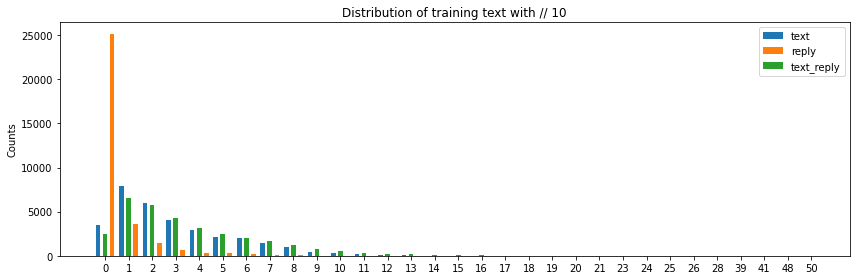

In [116]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

text_indices = np.arange(len(text_level))
reply_indices = np.arange(len(reply_level))
text_reply_indices = np.arange(len(text_reply_level))
# Plot results
fig, ax = plt.subplots(figsize=(12, 4))
width = 0.2
results_text = plt.bar(text_indices - 0.3, list(text_level.values()), width, label='text')
results_reply = plt.bar(reply_indices + 0.3, list(reply_level.values()), width, label='reply')
results_text_reply = plt.bar(text_reply_indices, list(text_reply_level.values()), width, label='text_reply')

plt.xticks(range(len(text_reply_level)), list(text_reply_level.keys()))
ax.set_ylabel('Counts')
ax.set_title('Distribution of training text with // 10')
# ax.set_xticks(x)
# ax.set_xticklabels(text_reply_indices)
ax.legend()

# autolabel(results_text)
# autolabel(results_reply)
# autolabel(results_text_reply)

fig.tight_layout()
plt.show()

In [117]:
torch.cuda.empty_cache()

## To-Do or Want-To-Do

- https://arxiv.org/pdf/1905.05583.pdf
    - [X] Try to count training and testing average length to modify max_seq_length
    - [ ] Head 128 + tail 382 when larger than 512 tokens get best results.
- [ ] [Exploratory Data Analysis](https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/?fbclid=IwAR07KpVViBMrZx5aboOMe2CPr4_QizPNoyW_Fdl6L1ZNN0_lhhGyl1KZxRg)
- [ ] [Blend models  10th](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/discussion/101630)
- [X] [Blend models 2nd](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/discussion/100661)
- [ ] [Data cleaning](https://www.kaggle.com/christofhenkel/how-to-preprocessing-for-glove-part1-eda)
- [ ] [Stopword removal](http://www.lrec-conf.org/proceedings/lrec2014/pdf/292_Paper.pdf)
- [ ] [Preprocess EDA](https://www.kaggle.com/christofhenkel/how-to-preprocessing-for-glove-part1-eda)
- [X] Shuffle data (no good)
- [ ] [Data cleaning](https://www.kaggle.com/theoviel/improve-your-score-with-text-preprocessing-v2)
- [ ] [EDA preprocessing DO FIRST!!](https://www.kaggle.com/nz0722/simple-eda-text-preprocessing-jigsaw)
    - [X] Check Roberta tokenizer proportion and data include proportion
    - [X] Draw text cloud (by Tommy)
- [ ] Add tokens to Roberta LM
- [X] try no limit max_seq in LM, no better than before
- [ ] Try TF-IDF in preprocessing

## Visualization

In [140]:
import seaborn as sns

### Visualize appears relation

In [222]:
relation_count = np.zeros([len(categories_mapping), len(categories_mapping)])
for idx in range(len(df)):
    for each_class_i in df['categories'][idx]:
        for each_class_j in df['categories'][idx]:
            i = categories_mapping[each_class_i]
            j = categories_mapping[each_class_j]
            relation_count[i][j] += 1
relation_count = pd.DataFrame(relation_count, columns=categories_mapping.keys(), dtype=int)

In [223]:
no = relation_count.iloc[18]
yes = relation_count.iloc[40]
yes_no_proportion = []
for i in range(len(no)):
    if no[i] == 0 and yes[i] == 0:
        yes_no_proportion.append(0)
    elif no[i] > yes[i]:
        if yes[i] != 0:
            yes_no_proportion.append(0)
        else:
            yes_no_proportion.append(-1)
    elif no[i] <= yes[i]:
        if no[i] != 0:
            yes_no_proportion.append(0)
        else:
            yes_no_proportion.append(1)

In [224]:
yes_no_relation = dict(zip(categories_type.values.tolist()[0], yes_no_proportion))

In [225]:
yes_no_relation

{'agree': 1,
 'applause': 1,
 'awww': 1,
 'dance': 0,
 'deal_with_it': 0,
 'do_not_want': -1,
 'eww': 0,
 'eye_roll': 1,
 'facepalm': -1,
 'fist_bump': 0,
 'good_luck': 0,
 'happy_dance': 1,
 'hearts': 0,
 'high_five': 0,
 'hug': 0,
 'idk': 0,
 'kiss': 0,
 'mic_drop': 0,
 'no': -1,
 'oh_snap': 1,
 'ok': 1,
 'omg': -1,
 'oops': 1,
 'please': 0,
 'popcorn': 0,
 'scared': 0,
 'seriously': 0,
 'shocked': 0,
 'shrug': 0,
 'sigh': -1,
 'slow_clap': 1,
 'smh': -1,
 'sorry': 0,
 'thank_you': 0,
 'thumbs_down': 0,
 'thumbs_up': 1,
 'want': 0,
 'win': 1,
 'wink': 0,
 'yawn': 0,
 'yes': 1,
 'yolo': 0,
 'you_got_this': 0}

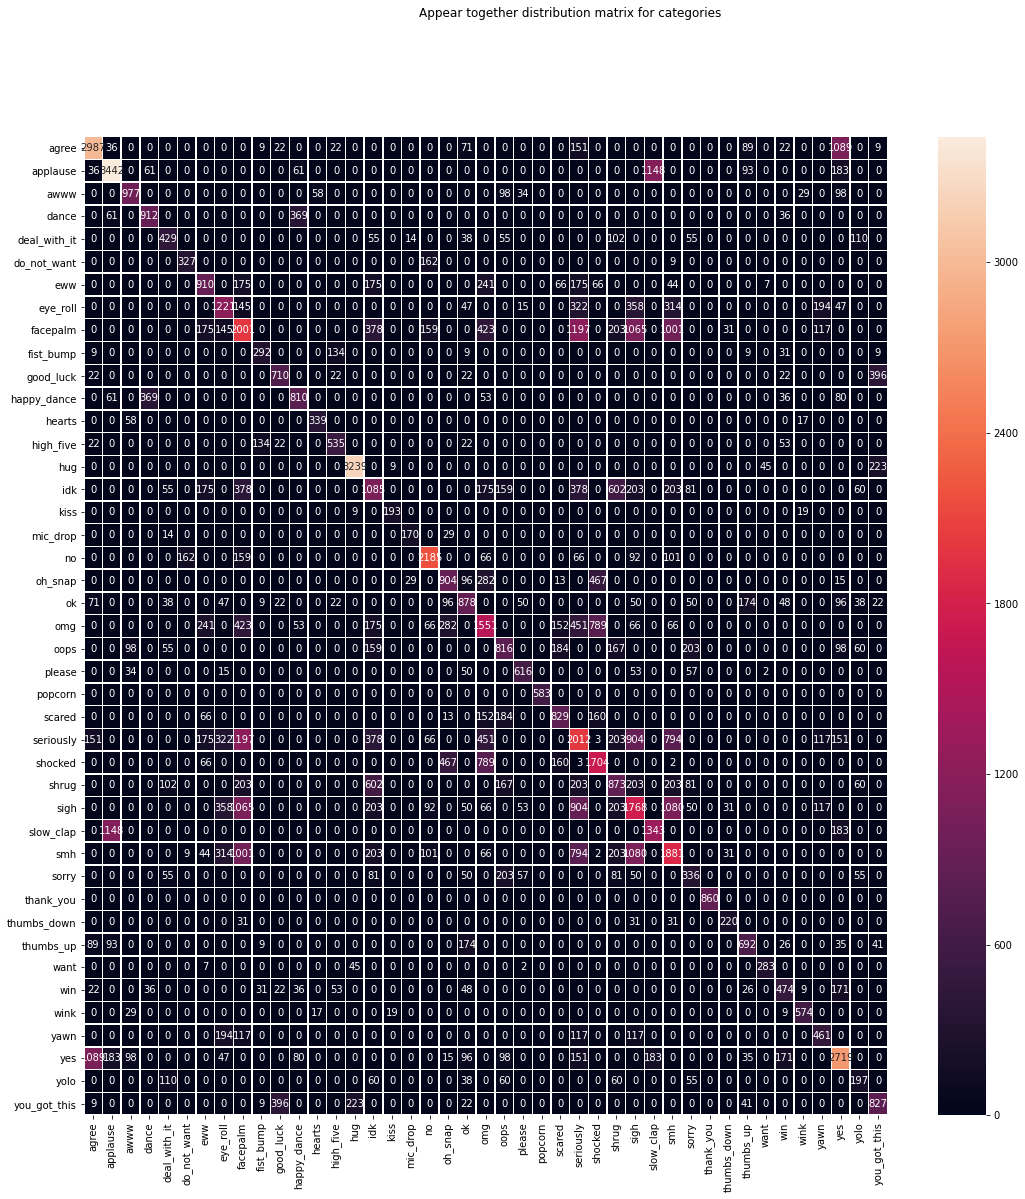

In [160]:
f, ax = plt.subplots(figsize=(18, 18))
f.suptitle('Appear together distribution matrix for categories')
sns.heatmap(relation_count, annot=True, linewidths=.5, ax=ax, fmt='d', xticklabels=categories_mapping.keys(), yticklabels=categories_mapping.keys())

### Visualization of training classes

In [137]:
total_classes = 0
categories_dict = defaultdict(lambda: 0)
for i in range(len(df)):
    for each_category in df['categories'][i]:
        categories_dict[each_category] += 1
        total_classes += 1
for key in categories_dict:
    categories_dict[key] = categories_dict[key]

Text(0.5, 1.0, 'Emotions Unnormalized')

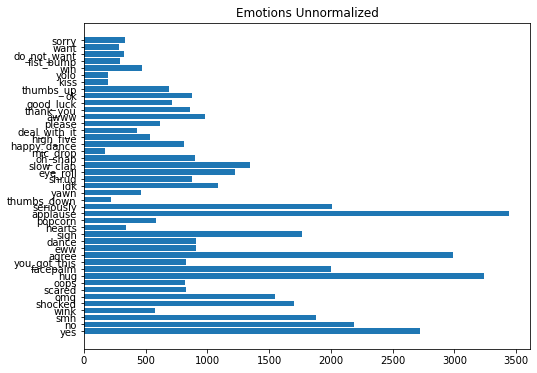

In [55]:
plt.figure(figsize=(8, 6))
plt.barh(list(categories_dict.keys()), categories_dict.values())
plt.title('Emotions Unnormalized')

In [58]:
for key in categories_dict:
    categories_dict[key] = np.log(categories_dict[key] / total_classes)
categories_dict

defaultdict(<function __main__.<lambda>()>,
            {'yes': -2.8319577695742577,
             'no': -3.0506061066770376,
             'smh': -3.200418384905698,
             'wink': -4.387347817887162,
             'shocked': -3.2992435068174673,
             'omg': -3.3933220510301894,
             'scared': -4.019757059071433,
             'oops': -4.035562859242622,
             'hug': -2.656957295035399,
             'facepalm': -3.1385748796229946,
             'you_got_this': -4.022172519183037,
             'agree': -2.7379523959906185,
             'eww': -3.926532614695833,
             'dance': -3.924337224132397,
             'sigh': -3.26237297100914,
             'hearts': -4.913977106826278,
             'popcorn': -4.371790027856236,
             'applause': -2.5961692374352436,
             'seriously': -3.1330926829870984,
             'thumbs_down': -5.3463496678543665,
             'yawn': -4.60657917121008,
             'idk': -3.7506419482321682,
             '

In [63]:
# # https://stackoverflow.com/questions/57021620/how-to-calculate-unbalanced-weights-for-bcewithlogitsloss-in-pytorch
# categories_dict_pos = categories_dict.copy()
# for key in categories_dict_pos:
#     categories_dict_pos[key] = (total_classes - categories_dict_pos[key]) / categories_dict_pos[key]
# categories_dict_pos

In [110]:
# class_weight = sorted(categories_dict.items(), key=lambda pair: categories_mapping[pair[0]])
# class_weight = [_[1] for _ in class_weight]
# class_weight

In [132]:
categories_mapping

{'agree': 0,
 'applause': 1,
 'awww': 2,
 'dance': 3,
 'deal_with_it': 4,
 'do_not_want': 5,
 'eww': 6,
 'eye_roll': 7,
 'facepalm': 8,
 'fist_bump': 9,
 'good_luck': 10,
 'happy_dance': 11,
 'hearts': 12,
 'high_five': 13,
 'hug': 14,
 'idk': 15,
 'kiss': 16,
 'mic_drop': 17,
 'no': 18,
 'oh_snap': 19,
 'ok': 20,
 'omg': 21,
 'oops': 22,
 'please': 23,
 'popcorn': 24,
 'scared': 25,
 'seriously': 26,
 'shocked': 27,
 'shrug': 28,
 'sigh': 29,
 'slow_clap': 30,
 'smh': 31,
 'sorry': 32,
 'thank_you': 33,
 'thumbs_down': 34,
 'thumbs_up': 35,
 'want': 36,
 'win': 37,
 'wink': 38,
 'yawn': 39,
 'yes': 40,
 'yolo': 41,
 'you_got_this': 42}

In [119]:
# 1: related yes, -1: related no, 0: otherwise
yes_no_relation = {'agree': 1,
 'applause': 1,
 'awww': 1,
 'dance': 0,
 'deal_with_it': 0,
 'do_not_want': -1,
 'eww': -1,
 'eye_roll': -1,
 'facepalm': -1,
 'fist_bump': 1,
 'good_luck': 1,
 'happy_dance': 1,
 'hearts': 0,
 'high_five': 1,
 'hug': 0,
 'idk': 0,
 'kiss': 0,
 'mic_drop': 0,
 'no': -1,
 'oh_snap': -1,
 'ok': 1,
 'omg': 0,
 'oops': 0,
 'please': 0,
 'popcorn': 0,
 'scared': -1,
 'seriously': 0,
 'shocked': 0,
 'shrug': 0,
 'sigh': -1,
 'slow_clap': 0,
 'smh': -1,
 'sorry': -1,
 'thank_you': 1,
 'thumbs_down': -1,
 'thumbs_up': 1,
 'want': 1,
 'win': 1,
 'wink': 0,
 'yawn': -1,
 'yes': 1,
 'yolo': 0,
 'you_got_this': 0}

In [120]:
Counter(yes_no_relation.values())

Counter({1: 13, 0: 18, -1: 12})